In [1]:
from requests import get
from requests.exceptions import RequestException
from contextlib import closing
from bs4 import BeautifulSoup
import json
import requests
print(requests.__version__)
import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statistics
%matplotlib inline

2.27.1


# Loading the data and exploring high level features

In [25]:
df=pd.read_csv('data/piki_dataset.csv')

In [67]:
df['year'] = pd.DatetimeIndex(df['timestamp']).year
df['month'] = pd.DatetimeIndex(df['timestamp']).month
df['superliked']=(df['liked']>1)*1
df['like_superlike']=(df['liked']>0)*1

In [68]:
df.tail()

,Unnamed: 0,timestamp,user_id,song_id,liked,personalized,spotify_popularity,treatment_group,year,month,like_superlike,superlike,superliked
1762497,1762497,2023-07-06 14:48:11,3744464,8075471,0,1,57,4,2023,7,0,0,0
1762498,1762498,2023-07-06 14:48:18,3744464,8084691,0,1,78,4,2023,7,0,0,0
1762499,1762499,2023-07-06 14:48:25,3744464,5395224,0,1,68,4,2023,7,0,0,0
1762500,1762500,2023-07-06 14:48:32,3744464,4189432,0,1,22,4,2023,7,0,0,0
1762501,1762501,2023-07-06 14:48:39,3744464,1759114,0,1,65,4,2023,7,0,0,0


In [69]:
num_ratings=len(df)
print(num_ratings)

1762502


In [70]:
users=df.groupby('user_id').mean()['like_superlike']
songs=df.groupby('song_id').mean()['like_superlike']

In [71]:
num_users=len(users)
print(num_users)

8896


In [72]:
num_ratings/num_users

198.12297661870502

In [73]:
users.mean()

0.5294860255601175

In [74]:
num_songs=len(songs)
print(num_songs)

246450


In [75]:
num_ratings/num_songs

7.15156015418949

In [76]:
songs.mean()

0.3264590235175532

In [77]:
users_rates=df.groupby('user_id').count()['song_id']
songs_rates=df.groupby('song_id').count()['user_id']

In [78]:
len(users_rates[users_rates>10])

6900

In [79]:
len(songs_rates[songs_rates>10])

27865

# The role of the user feedback mechanism

Voting timers are introduced on 2021-01-03

Before this date, users may immediately vote like/dislike/superlike

After this date, users must wait 3s to dislike, 6s to like and 12s to superlike

In [80]:
df_pre_timers=(df[((df['timestamp']<'2021-01-03'))])

In [81]:
df_pre_timers['like_superlike'].mean()

0.44968105579351686

In [82]:
df_post_timers=(df[((df['timestamp']>='2021-01-03'))])

In [83]:
df_post_timers['like_superlike'].mean()

0.43565820830214336

average like rate went down after this feature was implemented

In [84]:
def plot_histograms(df,thresh_users,thresh_songs,bins):
    users=df.groupby('user_id').mean()['like_superlike']
    songs=df.groupby('song_id').mean()['like_superlike']
    users_rates=df.groupby('user_id').count()['song_id']
    songs_rates=df.groupby('song_id').count()['user_id']
    users[users_rates[users_rates>thresh_users].index].hist(bins=bins)
    plt.figure()
    songs[songs_rates[songs_rates>thresh_songs].index].hist(bins=bins)

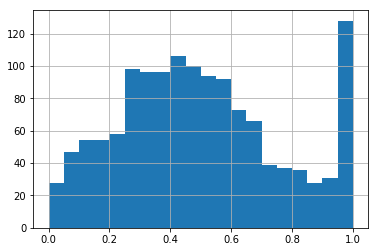

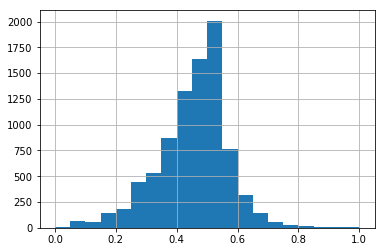

In [85]:
plot_histograms(df_pre_timers,10,10,20)

before implementing timers:
1) there is a significant proportion of users who like everything
2) the song like-ratio is peaked at 0.5

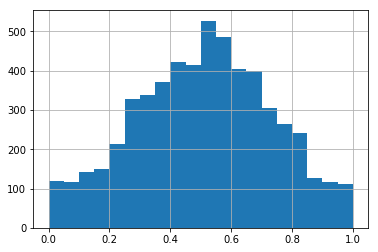

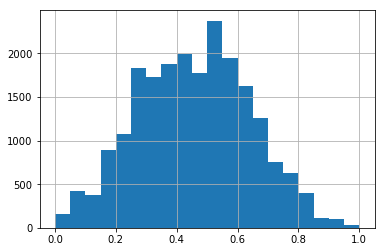

In [86]:
plot_histograms(df_post_timers,10,10,20)

after implementing timers:
1) users who like everything are greatly reduced
2) the song like-ratio is peaked at 0.25 and has a longer right tail

# The role of Spotify popularity
Songs with higher Spotify popularity are more often liked. This provides a benchmark for the liked rate of a song, given the popularity of its artist. This may help better quantify the role of popularity biases

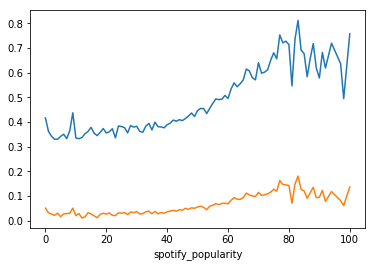

In [87]:
# all songs
df.groupby(['spotify_popularity']).mean()['liked'].plot()
df.groupby(['spotify_popularity']).mean()['superliked'].plot()

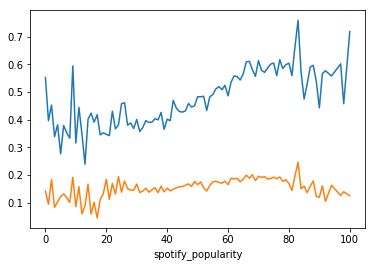

In [90]:
# all songs
a=df[df['treatment_group']==4].groupby(['spotify_popularity']).mean()['liked']
a.plot()
b=df[df['treatment_group']==4].groupby(['spotify_popularity']).mean()['superliked']
(b/a).plot()

# The role of recommendations based on previous ratings

Songs by artist that were previously liked (2) are better liked than personalized recommendations (1) are better liked than random recommendations (0)

This provides a benchmark for comparing obvious recommendations (2) to less obvious recommendations (1), to more suprising recommendations outside of one's echo chamber (0).

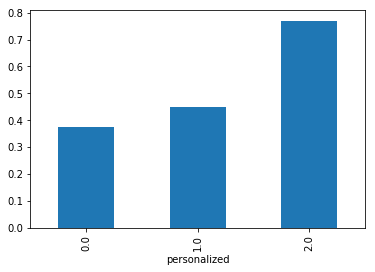

In [24]:
df.groupby(['personalized']).mean()['like_superlike'].plot.bar()

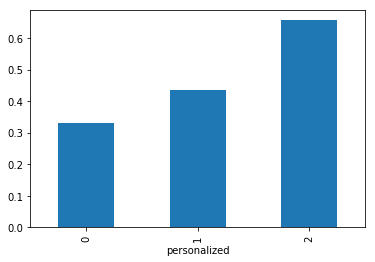

In [91]:
df[df['treatment_group']==4].groupby(['personalized']).mean()['like_superlike'].plot.bar()